# Crab Age Prediction using All Data

### Group members: Andrea Galval, Brandt Sandman, Nicholas Jurczyk

#### The data being used is downloaded from Kaggle.
##### https://www.kaggle.com/datasets/sidhus/crab-age-prediction/data

### Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
sns.set()

### Load and Inspect Data Set

In [4]:
# Fetch the file
original_data = pd.read_csv('CrabAgePrediction.csv') # Local, use full path if notebook and file in different folders! 

#Display What attributes we are working with in the Data
original_data.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


In [5]:
original_data.describe(include='all') # descriptive statistics for all columns

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,3893,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.311306,1.020893,0.349374,23.567275,10.207342,5.136546,6.795844,9.954791
std,NaN,0.300431,0.248233,0.104976,13.891201,6.275275,3.104133,3.943392,3.220967
min,NaN,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,NaN,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,NaN,1.362500,1.062500,0.362500,22.792998,9.539607,4.861939,6.662133,10.000000
75%,NaN,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000


In [6]:
original_data.isnull().sum() # check for null values

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

In [7]:
original_data[original_data.duplicated(keep=False)] # check for duplicate rows

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age


## Data Cleansing
#### Currently, the Sex of the crab is stored as a string (F/M/I for Male/Female/Indeterminate). We want to turn the string into a number. We will convert the string as follows:

##### F --> 0
##### M --> 1
##### I --> 2

In [9]:
#for the data, we need to turn the Label into a number so we can compare if we predicted the right thing.
# Step 1: Create a mapping dictionary
mapping = {
    'F': 0,
    'M': 1,
    'I': 2
}

# Step 2: Apply the mapping to the specific column
original_data['Sex'] = original_data['Sex'].map(mapping)

original_data.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,1,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,2,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,0,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,2,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


### We also only care about if a crab is edible or not. We don't care about how old the crab is in months. As such, we will re-classify the data so that we only look at if the crab is old enough to eat or not.

#### A crab is considered ready to eat starting at 12 months of age.

In [11]:
# Code source: ChatGPT
# Remap the 'age' column where age > 12 becomes 1 and age <= 12 becomes 0
original_data['Age'] = original_data['Age'].apply(lambda x: 1 if x > 11 else 0)

original_data.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,0
1,1,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,0
2,2,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,0
3,0,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,0
4,2,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,0


# Splitting the Data into Testing and Training Datasets

In [20]:
target = original_data["Age"]
predictors = original_data.drop(["Age"], axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    predictors, target, test_size=0.2, random_state=42
)  # 80-20 split into training and test data

##### Check if the dataset is balanced.

In [25]:
# Check data balancing
y_train.value_counts()

# There is no severe skew in the class distribution. No resampling needed.
# If you want to learn more about resampling, also check https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

Age
0    2368
1     746
Name: count, dtype: int64

## Predictor Selection

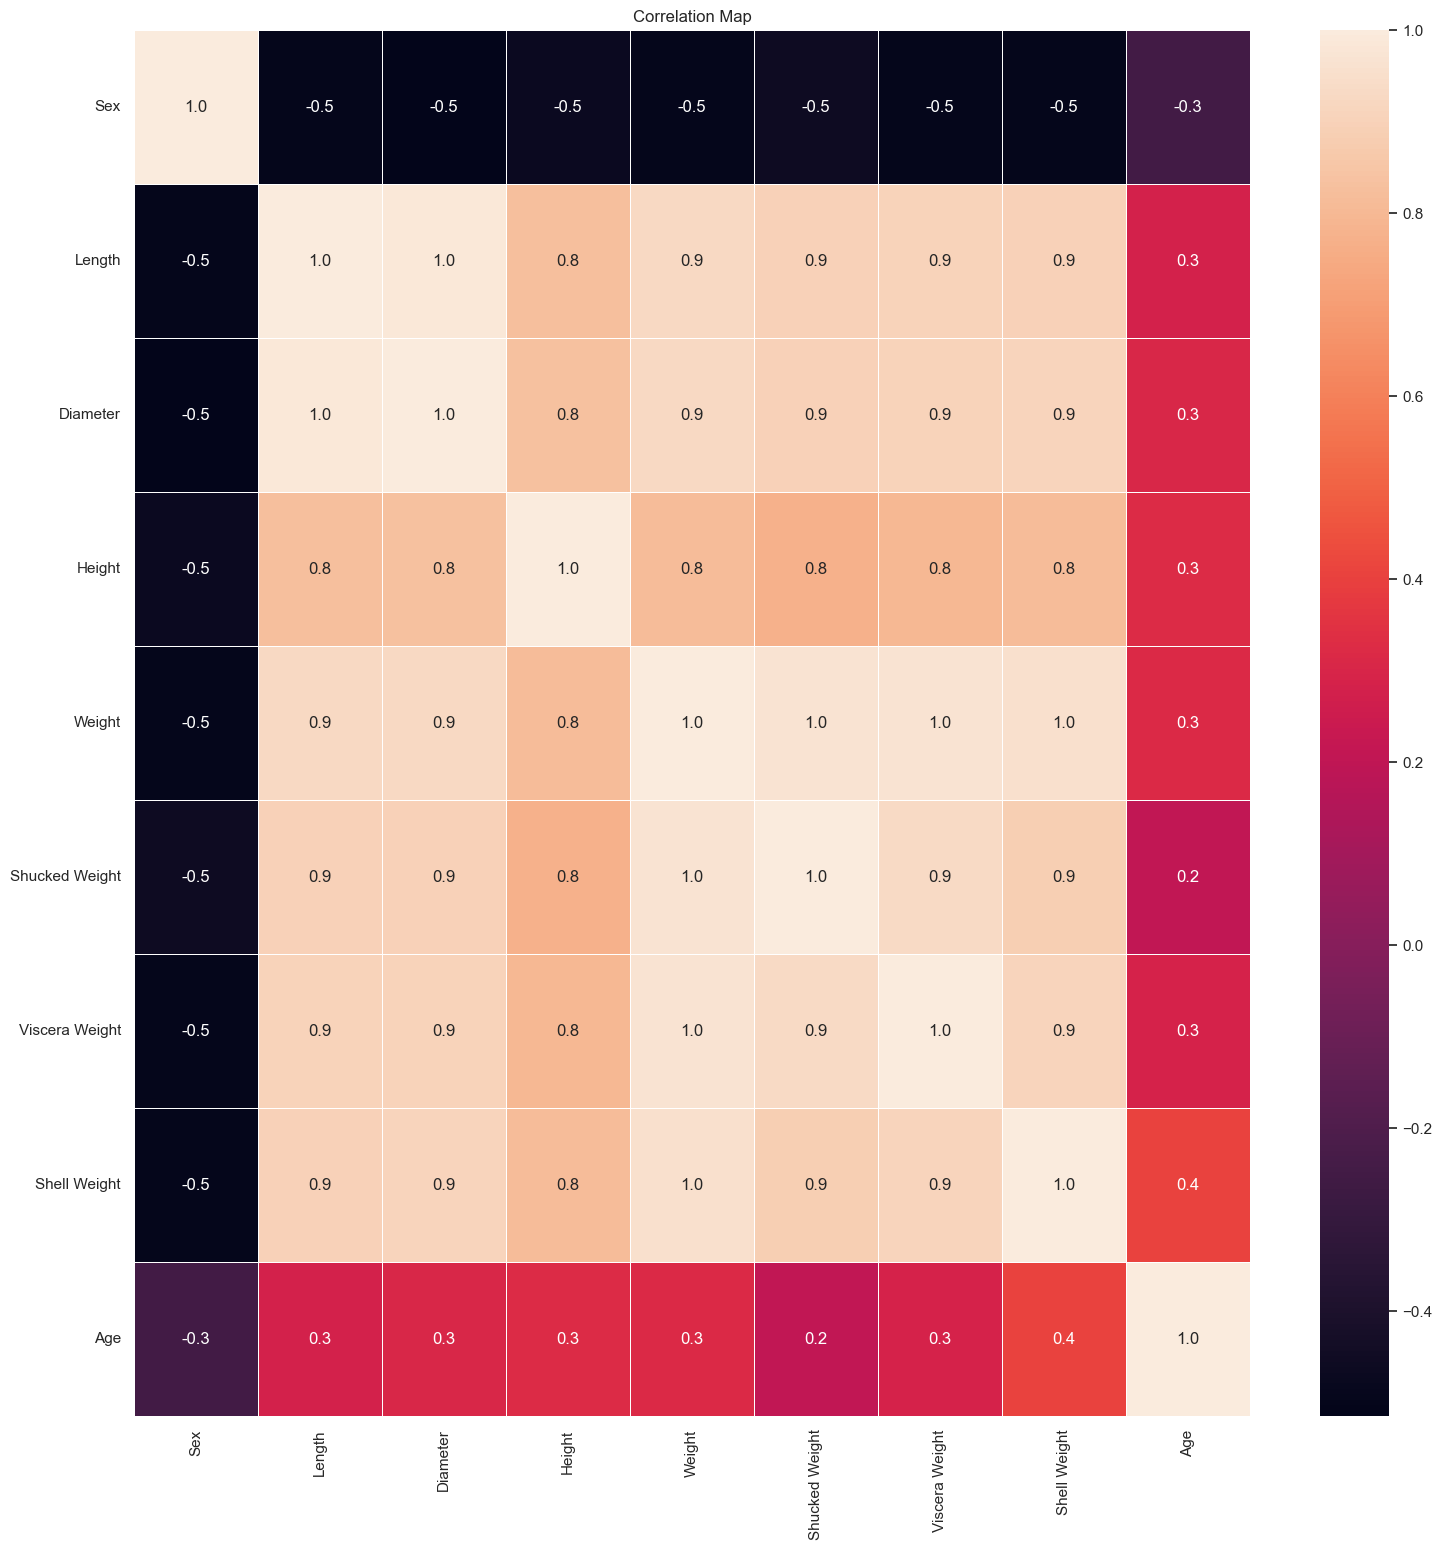

In [28]:
#Create a Heat Map to better understand 
f,ax=plt.subplots(figsize = (18,18))
sns.heatmap(original_data.corr(),annot= True,linewidths=0.5,fmt = ".1f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

## Apply

In [39]:
# Code from ChatGPT
from sklearn.neighbors import KNeighborsClassifier
# Step 1: Initialize the KNN model, specify number of neighbors (k)
# Tests conducted between 1-15. 8 yielded the best results.
k = 8 # You can experiment with different values of k
knn = KNeighborsClassifier(n_neighbors=k)

# Step 2: Train the KNN model on the training dataset
knn.fit(X_train, y_train)

# Step 3: Use the trained model to make predictions on the test dataset
y_pred = knn.predict(X_test)

# Step 4: Evaluate the model

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8421052631578947


In [41]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Step 1: Initialize the RBF SVM model
rbf_svm = SVC(kernel='rbf')

# Step 2: Train the RBF SVM model on the training data
rbf_svm.fit(X_train, y_train)

# Step 3: Make predictions using the trained model on the test data
y_pred = rbf_svm.predict(X_test)

# Step 4: Evaluate the model

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8369704749679076


In [49]:
# Code from ChatGPT

# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Step 1: Initialize the Logistic Regression model
log_reg_model = LogisticRegression()

# Step 2: Train the model on the training data
log_reg_model.fit(X_train, y_train)

# Step 3: Make predictions using the trained model on the test data
y_pred = log_reg_model.predict(X_test)

# Step 4: Evaluate the model

# 4.1. Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.834403080872914


In [51]:
# Code from ChatGPT

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Step 1: Initialize the Random Forest model
# n_estimators is the number of trees in the forest (can be tuned)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 2: Train the model on the training data
rf_model.fit(X_train, y_train)

# Step 3: Make predictions using the trained model on the test data
y_pred = rf_model.predict(X_test)

# Step 4: Evaluate the model

# 4.1. Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8202824133504493
